In [3]:
import os
import sys

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Now you can import the module from the examples directory
from examples.ista import sol_2_obj_diff
import time
import jax.numpy as jnp
import scs
import numpy as np
from scipy.sparse import csc_matrix
from l2ws.algo_steps import k_steps_eval, k_steps_train_ista, create_projection_fn, lin_sys_solve, k_steps_train_fista
import jax.scipy as jsp
import pytest
import matplotlib.pyplot as plt
from l2ws.ista_model import ISTAmodel
import cvxpy as cp
from jax import vmap
from functools import partial
from examples.ista import generate_b_mat
from scipy.spatial import distance_matrix
from examples.ista import sol_2_obj_diff, solve_many_probs_cvxpy
from l2ws.utils.nn_utils import get_nearest_neighbors

/Users/rajivs/Documents/Princeton/l2ws_conic/env/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


(CVXPY) Apr 26 02:27:20 PM: Encountered unexpected exception importing solver OSQP:
ImportError("dlopen(/Users/rajivs/Documents/Princeton/l2ws_conic/env/lib/python3.9/site-packages/osqp/_osqp.cpython-39-darwin.so, 0x0002): symbol not found in flat namespace '_csc_matrix'")


In [25]:
# ista setup
N_train = 100
N_test = 20
N = N_train + N_test
m, n = 50, 25
A = jnp.array(np.random.normal(size=(m, n)))
b_mat = jnp.array(np.random.normal(size=(N, m)))
# b_mat = generate_b_mat(A, N)
k = 200
z0 = jnp.zeros(n)
lambd = .005
evals, evecs = jnp.linalg.eigh(A.T @ A)
ista_step = 1 / jnp.max(evals)

# setup inputs
b_mat_train = b_mat[:N_train, :]
b_mat_test = b_mat[N_train:, :]
train_inputs = b_mat_train
test_inputs = b_mat_test

In [26]:
 # solve with cvxpy
z_stars, objvals = solve_many_probs_cvxpy(A, b_mat, lambd)
objvals_train = objvals[:N_train]
objvals_test = objvals[N_train:]
z_stars_train = z_stars[:N_train, :]
z_stars_test = z_stars[N_train:, :]

# create relative obj fn
partial_rel = partial(sol_2_obj_diff, A=A, lambd=lambd)
batch_rel = vmap(partial_rel, in_axes=(0, 0, 0), out_axes=(0))
batch_rel_mat = vmap(batch_rel, in_axes=(1, None, None), out_axes=(0))

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Apr 26 02:31:45 PM: Your problem has 25 variables, 0 constraints, and 50 parameters.
(CVXPY) Apr 26 02:31:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 26 02:31:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 26 02:31:45 PM: Compiling problem (target solver=ECOS).
(CVXPY) Apr 26 02:31:45 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Apr 26 02:31:45 PM: Applying reduction Dcp2Cone
(CVXPY) Apr 26 02:31:45 PM: Applying reduction CvxAttr2Constr
(CVXPY)

In [27]:
# create l2ws_model
# nn_cfg = {'lr': 1e-5} 
nn_cfg = {}
# nn_cfg = {'intermediate_layer_sizes': [200]} #, 'lr': 1e-1}
train_unrolls = 50
input_dict = dict(algorithm='ista',
                    supervised=False,
                    train_unrolls=train_unrolls, 
                    jit=True,
                    train_inputs=train_inputs, 
                    test_inputs=test_inputs,
                    b_mat_train=b_mat_train, 
                    b_mat_test=b_mat_test,
                    lambd=lambd,
                    ista_step=ista_step,
                    A=A,
                    nn_cfg=nn_cfg,
                    z_stars_train=z_stars_train,
                    z_stars_test=z_stars_test,
                    )
l2ws_model = ISTAmodel(input_dict)

In [28]:
# full evaluation on the test set with nearest neighbor
nearest_neighbors_z = get_nearest_neighbors(train_inputs, test_inputs, z_stars_train)
nn_eval_out = l2ws_model.evaluate(k, nearest_neighbors_z, b_mat_test, z_stars=z_stars_test, fixed_ws=True, tag='test')
nn_z_all = nn_eval_out[1][3]
nn_rel_objs = batch_rel_mat(nn_z_all, b_mat_test, objvals_test).mean(axis=1)
nn_losses = nn_eval_out[1][1].mean(axis=0)

# evaluate test before training
init_test_loss, init_time_per_iter = l2ws_model.short_test_eval()

# full evaluation on the test set
init_eval_out = l2ws_model.evaluate(k, test_inputs, b_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
init_test_losses = init_eval_out[1][1].mean(axis=0)
init_z_all = init_eval_out[1][3]
init_rel_objs = batch_rel_mat(init_z_all, b_mat_test, objvals_test).mean(axis=1)

distances [[10.23483036  8.37719027 10.39228873 ...  9.21932412  9.58659228
  10.079672  ]
 [10.10425337  9.02970174  9.31304448 ... 10.06986934  9.73496115
   9.45727766]
 [10.7019422  10.4968706  11.96568299 ... 10.33789155 10.40197516
   9.72399858]
 ...
 [ 8.91708253  9.3197856   8.76764158 ...  8.58697666  7.93471806
   7.46759452]
 [ 8.92009571  9.65704565  8.42963748 ...  9.36024517  9.69709287
  10.06837323]
 [ 9.83018609  9.18938184  9.09462309 ... 10.09884375  9.42090672
   9.54295697]]
indices [ 7 65 61 70 54 70 31 98  1 31  8 31 78  1 65 90 78 93  5 81]
best val [7.05430674 7.19194431 9.39943984 7.32933681 7.96430907 8.53362218
 7.67296947 8.75819286 7.12144866 8.2921847  7.3154215  7.25567692
 8.54472018 6.93919534 8.42134176 7.8995934  7.85385451 7.43979606
 7.40014301 7.89306143]


In [29]:
# call train_batch without jitting
params, state = l2ws_model.params, l2ws_model.state
num_epochs = 1000
losses = jnp.zeros(num_epochs)
for i in range(num_epochs):
    train_result = l2ws_model.train_full_batch(params, state)
    loss, params, state = train_result
    losses = losses.at[i].set(loss)

l2ws_model.params, l2ws_model.state = params, state

In [30]:
# evaluate test after training
final_test_loss, final_time_per_iter = l2ws_model.short_test_eval()

# full evaluation on the test set
final_eval_out = l2ws_model.evaluate(k, test_inputs, b_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
final_z_all = final_eval_out[1][3]
final_rel_objs = batch_rel_mat(final_z_all, b_mat_test, objvals_test).mean(axis=1)

final_test_losses = final_eval_out[1][1].mean(axis=0)

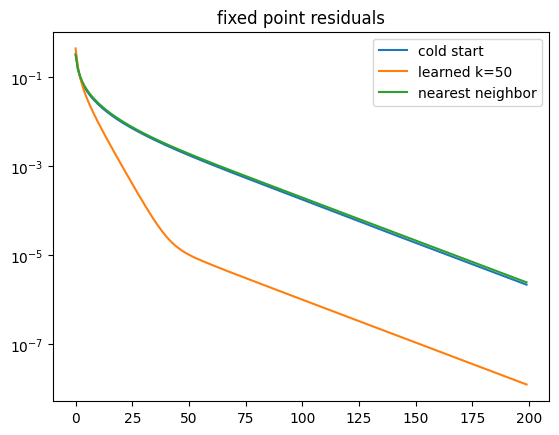

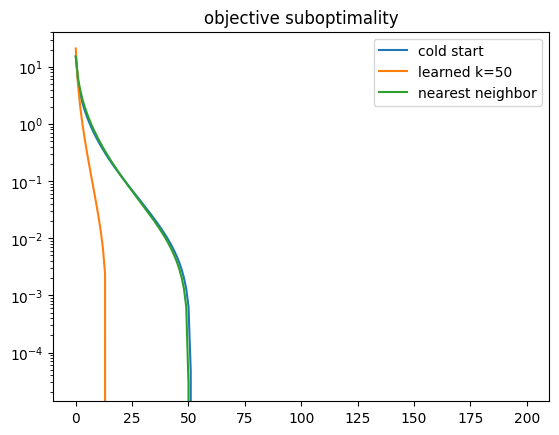

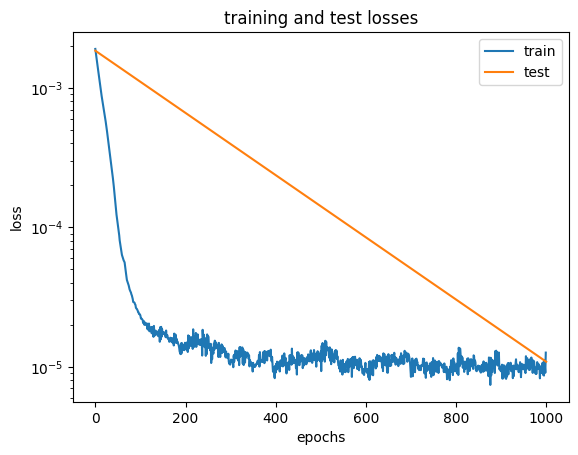

In [31]:
plt.plot(init_test_losses, label='cold start')
plt.plot(final_test_losses, label=f"learned k={train_unrolls}")
plt.plot(nn_losses, label='nearest neighbor')
plt.yscale('log')
# plt.xscale('log')
plt.title('fixed point residuals')
plt.legend()
plt.show()

plt.plot(init_rel_objs, label='cold start')
plt.plot(final_rel_objs, label=f"learned k={train_unrolls}")
plt.plot(nn_rel_objs, label='nearest neighbor')
plt.yscale('log')
# plt.xscale('log')
plt.title('objective suboptimality')
plt.legend()
plt.show()

plt.plot(losses, label='train')
test_losses = np.array([init_test_loss, final_test_loss])
epochs_array = np.array([0, num_epochs])
plt.plot(epochs_array, test_losses, label='test')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.yscale('log')
plt.title('training and test losses')
plt.legend()
plt.show()